# Demodulating an FM signal

**Jakub Bliźniuk**

Let's start by loading and looking at our signal. We can use scipy's wavfile module to load the `.wav` data as numpy arrays:

In [223]:
from scipy.io import loadmat
from scipy.signal import butter, sosfilt, resample_poly,decimate
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # ignore complex value truncation warning

In [27]:
file = np.genfromtxt("C3qam4-04-06-2024__02.csv", delimiter=",")
data = file[:,1]
fs = 250_000_000

We know from the file name that we're using a 300kHz carrier frequency

In [43]:
length = data.shape[0] / fs
time = file[:,0]#np.linspace(0., length, data.shape[0])
fc = 400_000.0 # carrier frequency

In [44]:
print(data.shape)
print(fs)
print(length)

(2500002,)
250000000
0.010000008


Let's see how it looks - at least a small part of it:

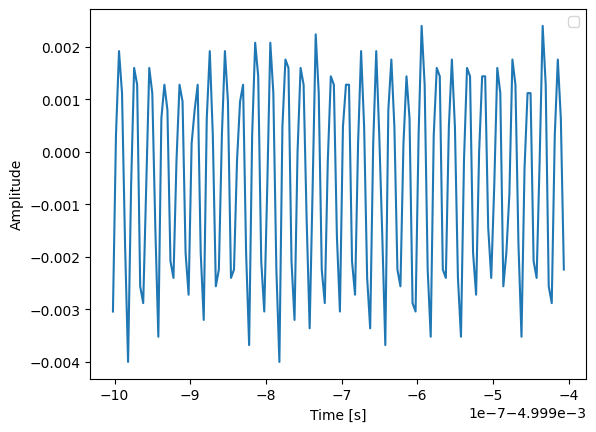

In [33]:
plt.plot(time[0:150], data[0:150])
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

Let's see its Fourier Transform - maybe it'll help:

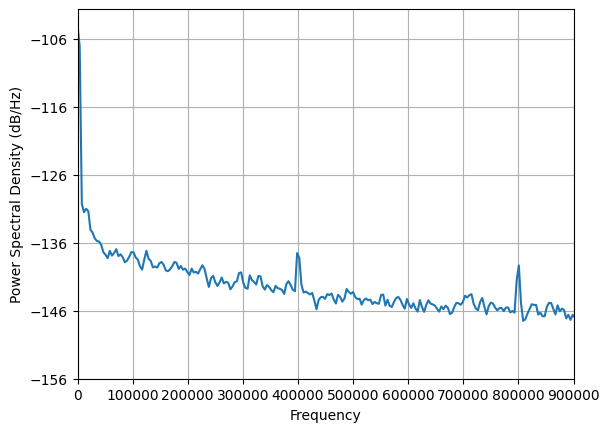

<Figure size 1000x200 with 0 Axes>

In [42]:
plt.psd(data, Fs=fs, NFFT=64000)
plt.xlim([0, 900_000])
plt.figure(figsize= (10,2))
plt.show()

So as we can see, there are peaks at 400 and 800 kHz - which matches our actual data (400kHz) and the expected repetition

## Tuning and filtering

First we'll need to "tune in" to the frequency of our channel - 400000kHz.

We'll start with the observation that our two channels aren't actually stereo. For FM that's done by moving the second channel over to be centered at 38kHz and indicating its presence via a pilot tone at 19kHz (since there can be mono broadcasts and devices that don't support two channels). So what are they? Well, considering we have two channels with only real data, we can take an educated guess - our actual signal has in-phase and quadrature components, so we're probably getting these as separate channels. We can therefore reconstruct it by just turning it into one:

In [45]:
def rms(x):
    return np.sqrt(np.mean(np.square(x)))

In [112]:
x_i = data*np.cos(2*np.pi*50_000_000*time)/rms(data) * np.sqrt(2)
x_q = data*np.sin(2*np.pi*50_000_000*time)/rms(data) * np.sqrt(2)

Możemy teraz przejechać sygnał filtrem dolnopasmowym na 400kHz:

In [113]:
initialFilt = butter(40, 500_000, fs=fs, output='sos')
x_i_f = sosfilt(initialFilt, x_i)
x_q_f = sosfilt(initialFilt, x_q)

As we can see, the filter got rid of aliasing here:

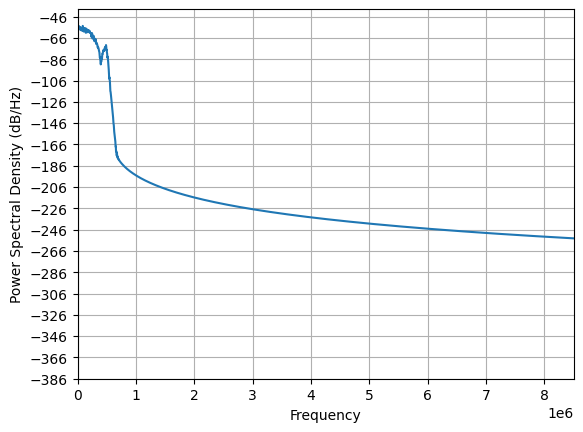

<Figure size 1000x200 with 0 Axes>

In [114]:
plt.psd(x_i_f, Fs=fs, NFFT=64000)
plt.xlim([0, 8500_000])
plt.figure(figsize= (10,2))
plt.show()

Now we can downsample our signal to a reasonable rate - we can get to 1sps by downsampling by a factor of 625 (note that we're calling decimate multiple times, as its filters can give worse results with a factor >13):

In [115]:
x_i_d = decimate(x_i_f, 5)
x_i_d = decimate(x_i_d, 5)
x_i_d = decimate(x_i_d, 5)
x_i_d = decimate(x_i_d, 5)

x_q_d = decimate(x_q_f, 5)
x_q_d = decimate(x_q_d, 5)
x_q_d = decimate(x_q_d, 5)
x_q_d = decimate(x_q_d, 5)

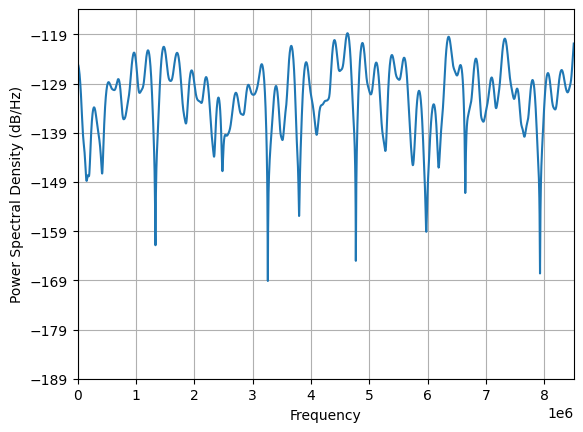

<Figure size 1000x200 with 0 Axes>

In [116]:
plt.psd(x_i_d, Fs=fs, NFFT=64000)
plt.xlim([0, 8500_000])
plt.figure(figsize= (10,2))
plt.show()

In [117]:
signal = x_i_d + 1j * x_q_d

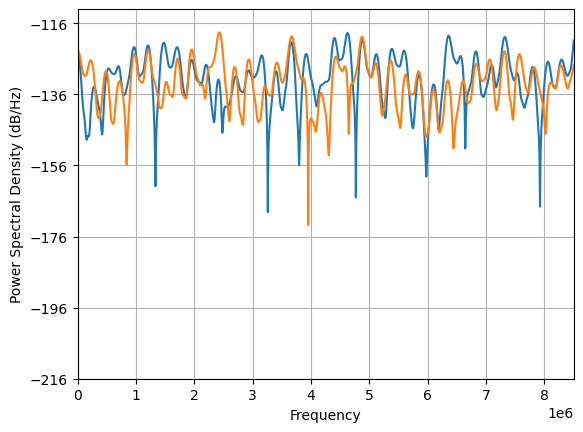

<Figure size 1000x200 with 0 Axes>

In [118]:
plt.psd(x_i_d, Fs=fs, NFFT=64000)
plt.psd(x_q_d, Fs=fs, NFFT=64000)

plt.xlim([0, 8500_000])
plt.figure(figsize= (10,2))
plt.show()

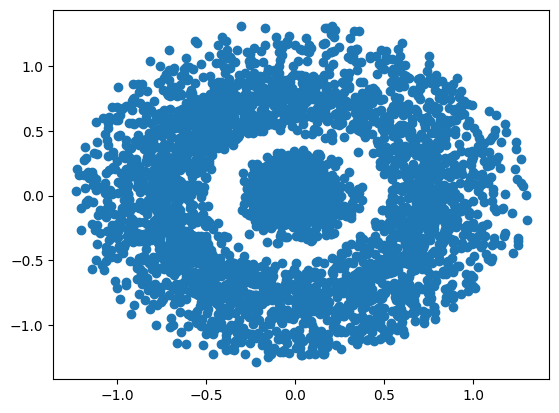

<Figure size 1000x200 with 0 Axes>

In [120]:
plt.scatter(x_i_d, x_q_d)
plt.figure(figsize= (10,2))
plt.show()

As we see, we have a donut and not a nice constellation. That's because we our timing doesn't match the transmitter's - we need to somehow correct for sampling time and phase differences...

We can do so using two PLLs - a Mueller and Muller timing synchronization algorithm and a Costas loop

In [259]:
def mueller_and_muller(signal, sps=1):
    mu = 0
    out = np.zeros(len(signal) + 10, dtype=np.complex64)
    out_rail = np.zeros(len(signal) + 10, dtype=np.complex64)
    i_in = 0
    i_out = 2
    while i_out < signal.shape[0] and i_in+16 < signal.shape[0]:
        out[i_out] = signal[i_in + int(mu)]
        out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
        x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
        y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
        mm_val = np.real(y - x)
        mu += sps + 0.3*mm_val
        i_in += int(np.floor(mu))
        mu = mu - np.floor(mu)
        i_out += 1
    return out[2:i_out]
def phase_detector_qpsk(sample):
    a = 1.0 if sample.real > 0 else -1.0
    b = 1.0 if sample.imag > 0 else -1.0
    return a * sample.imag - b * sample.real
def simple_costas(signal, alpha=0.1, beta=0.01):
    """
    Simple Costas Loop implementation for QPSK demodulation.

    signal - single channel signal (n_samples,)
    fs - sampling frequency
    alpha - loop gain
    beta - damping factor
    """
    phase = 0
    freq = 0
    out = np.zeros(signal.shape[0], dtype=np.complex64)
    for i in range(signal.shape[0]):
        out[i] = signal[i] * np.exp(-1j*phase)
        error = phase_detector_qpsk(out[i]) #np.real(out[i]) * np.imag(out[i])
        freq += (beta * error)
        phase += freq + (alpha * error)
        while phase >= 2*np.pi:
            phase -= 2*np.pi
        while phase < 0:
            phase += 2*np.pi
    return out


In [267]:
time_synced = mueller_and_muller(x_i_f+1j*x_q_f, sps=fs//fc)
freq_synced = simple_costas(time_synced, alpha=0.4, beta=0.01)


And after we correct for these our signal starts looking as it should:

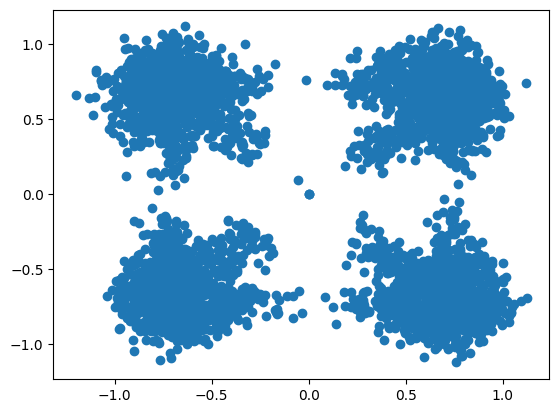

<Figure size 1000x200 with 0 Axes>

In [268]:
plt.scatter(np.real(freq_synced), np.imag(freq_synced))
plt.figure(figsize= (10,2))
plt.show()

And now we can finally try recovering the data:

In [346]:
data = (np.real(freq_synced)>0) + 2*(np.imag(freq_synced)>0)

Compare to source of truth:

In [347]:
mat = loadmat("nadane_matlab__02.mat")

Unfortunately, it seems we've found only 1/4th of all symbols:

In [348]:
def sym_sync(data, truth):
    # find the best offset
    best_offset = 0
    score = 0
    for offset in range(0, data.shape[0]-truth.shape[0], 1):
        xor = np.bitwise_xor(data[offset:offset+truth.shape[0]], truth)
        xor = np.sum(xor)
        if xor < score or score == 0:
            best_offset = offset
            score = xor
    return data[best_offset:best_offset+truth.shape[0]]

In [352]:
truth = mat['d1'][0,:]

In [353]:
fixed = sym_sync(data, truth)

In [354]:
sum(fixed == truth)

291

But it's *something*, I guess :)